In [103]:
from glob import glob
import pandas as pd
import time
import asyncio
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from datetime import datetime
import random
from math import exp, pow
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [104]:
import torchvision.transforms as T

In [105]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

from skimage import io
import matplotlib.image as mpimg

In [106]:
from imgaug import augmenters  as iaa
from torchvision.io import read_image, ImageReadMode
import torch

In [107]:
dfs = list()
# for filename in glob("E:/data/training_data/annotations2/*"):
#     temp_df = pd.read_csv(filename)
#     # temp_df['filename'] = filename
#     # print(temp_df.shape[0])
#     dfs.append(temp_df)
for filename in glob("E:/data/training_data/annotations/v2/*"):
    path = int(Path(filename).stem)
    temp_df = pd.read_csv(filename)
    # temp_df['filename'] = filename
    # print(temp_df.shape[0])
    dfs.append(temp_df)



In [108]:
df_all = pd.concat(dfs)
df_all=df_all.reset_index()
# df['image'] = df.image.str.replace("temp2", "temp")
df_all.shape

(321918, 7)

In [220]:
train_df, test_df = train_test_split(df_all, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [223]:
print(train_df.shape, train_df.x.min(), train_df.x.max())
print(test_df.shape, test_df.x.min(), test_df.x.max())
print(val_df.shape, val_df.x.min(), val_df.x.max())

(206027, 7) -32768 32767
(64384, 7) -32768 32767
(51507, 7) -32768 32767


In [224]:
# df = pd.read_csv("E:/data/training_data/annotations_200k_v2.csv")

In [225]:
def scatter_plot(x, y):
    # plt.style.use(plot_name)
    # size and color:
    # plot
    sizes = np.random.uniform(15, 80, len(x))
    colors = np.random.uniform(15, 80, len(x))
    fig, ax = plt.subplots()
    ax.scatter(x, y,  s=sizes, c=colors, vmin=0, vmax=100)

In [226]:
def bar_plot(x, y):
    # plt.style.use(plot_name)
    # size and color:
    # plot
    sizes = np.random.uniform(15, 80, len(x))
    colors = np.random.uniform(15, 80, len(x))
    fig, ax = plt.subplots()
    ax.hi(x, y,  s=sizes, c=colors, vmin=0, vmax=100)

In [227]:
x_bin_size = 500

train_df['x_bin'] = train_df['x'].apply(lambda x: x_bin_size * (x//x_bin_size))
train_df['rt_bin'] = train_df['rt'].apply(lambda x: 10 * (x//10))
train_df['lt_bin'] = train_df['lt'].apply(lambda x: 10 * (x//10))

In [228]:
hist, bins = np.histogram(train_df['x'], bins=130)
center = (bins[:-1] + bins[1:]) * 0.5

In [229]:
train_df['x1'] = train_df.x +32767+ 2

In [234]:
# y_x_log_transformed = stats.boxcox(df_all['x1'])
# df_agg = df_all[['x1_bin']].groupby('x1_bin').size().reset_index().rename(columns = {0: "count"})
# px.bar(x=df_agg.x_bin.values, y=df_agg['count'].values)

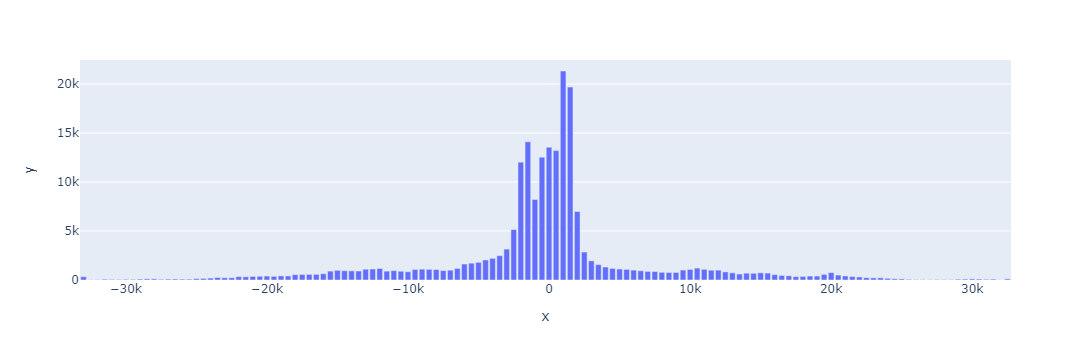

In [235]:
df_agg = train_df[['x_bin']].groupby('x_bin').size().reset_index().rename(columns = {0: "count"})
px.bar(x=df_agg.x_bin.values, y=df_agg['count'].values)

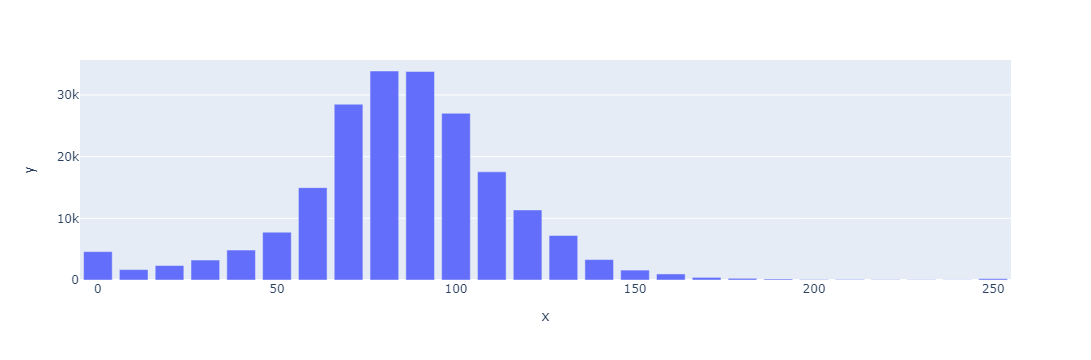

In [236]:
df_agg = train_df[['rt_bin']].groupby('rt_bin').size().reset_index().rename(columns = {0: "count"})
px.bar(x=df_agg.rt_bin.values, y=df_agg['count'].values)

In [237]:
# df_agg = df[['lt_bin']].groupby('lt_bin').size().reset_index().rename(columns = {0: "count"})
# px.scatter(x=df_agg.lt_bin.values, y=df_agg['count'].values)

# Balance Data

In [238]:
def flip_img(imgs): 
    seq = iaa.Sequential([
        # iaa.Crop(px=(0, 40)), # crop images from each side by 0 to 16px (randomly chosen)
        # iaa.Resize(0.95),
        iaa.Fliplr(1.0), # horizontally flip 50% of the images
        # iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
        # iaa.Multiply((0.2, 1)),
        # iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
    ])
    return seq(images=imgs)

In [239]:
aug_img_path = "E:/data/training_data/images/v2_aug"
def flip_img_path(image):
    src_imgpath = Path(image)
    return os.path.join(aug_img_path, "flip_"+src_imgpath.name)

In [240]:
def flip_data(df): 
    df['flip_image'] = df.image.apply(flip_img_path)
    df['x'] = -df['x']
    for t in df.itertuples(): 
        img = cv2.imread(t.image)
        aug_img = flip_img([img])[0]
        cv2.imwrite(t.flip_image, aug_img)
    df['image'] = df['flip_image']
    del df['flip_image']
    return df

In [241]:
# df = df_all[(df_all.x > 15000) & (df_all.x < 55000)]
# df = df[-150000:]

# Handle Data Imbalance

## Helper Functions

In [242]:
def balance_data(df, freq, y, bins):
    balanced_dfs = list()
    bins_size = len(bins)
    half = bins_size//2
    for i in range(bins_size-1):
        if freq[i] >= y[i]: 
            temp_df = df[(df['x'] >= bins[i]) & (df['x'] < bins[i+1])]
            before_shape = temp_df.shape[0]
            temp_df = temp_df[-math.floor(y[i]):]
            after_shape = temp_df.shape[0]
            # print(f"{i}, bins={bins[i], bins[i+1]}, freq={freq[i]}, y={y[i]}, before_shape={before_shape}, after_shape={after_shape}")
            balanced_dfs.append(temp_df)
        else: 
            sample_size = math.floor(y[i] - freq[i])
            if i <= half:
                print(f"[LEFT] Flip {i}, left={bins[i], bins[i+1]}, right={ bins[bins_size-i-2], bins[bins_size-i-1]}, y={y[i]}, freq={freq[i]}, size={sample_size}")
                flip_df = df[(df['x'] >= bins[bins_size-i-2]) & (df['x'] < bins[bins_size-i-1])]
                sample_size = min(flip_df.shape[0], sample_size)
                flip_df = flip_data(flip_df[-sample_size:].copy())
                balanced_dfs.append(df[(df['x'] >= bins[i]) & (df['x'] < bins[i+1])])
                balanced_dfs.append(flip_df)
            else: 
                print(f"[RIGHT] Flip {i}, left={bins[bins_size-i-2], bins[bins_size-i-1]}, right={ bins[i], bins[i+1]}, y={y[i]}, freq={freq[i]}, size={sample_size}")
                flip_df = df[(df['x'] >= bins[bins_size-i-2]) & (df['x'] < bins[bins_size-i-1])]
                sample_size = min(flip_df.shape[0], sample_size)
                flip_df = flip_data(flip_df[-sample_size:]).copy()
                balanced_dfs.append(flip_df)
                balanced_dfs.append(df[(df['x'] >= bins[i]) & (df['x'] < bins[i+1])])
    return pd.concat(balanced_dfs)

In [243]:
def dist_with_pdf(data, bin_size=130, pdf_scale=.5e8):
    freq, bins = np.histogram(data, bins=bin_size)

    # calculate mean and standard deviation
    mean = np.mean(data)
    std = np.std(data)
    var = np.var(data)
    print(mean, std, var)

    # create x-axis values for the normal distribution curve
    mu = 0
    sigma = math.sqrt(var)
    x = np.linspace(min(bins), max(bins), bin_size)


    # calculate the y-axis values for the normal distribution curve
    y = stats.norm.pdf(x, mean, std) * pdf_scale

    fig = go.Figure([
        go.Bar(x=bins[:-1], y=freq), 
        go.Scatter(x=x, y=y),
    ])
    return freq, y, bins, fig

In [244]:
def determine_outlier_thresholds_std(dataframe, col_name):
    upper_boundary = dataframe[col_name].mean() + 3 * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() - 3 * dataframe[col_name].std()
    return lower_boundary, upper_boundary

## Balance Train Data

### Plot Train Data

-75.33063627582793 7886.93950557535 62203814.76460515


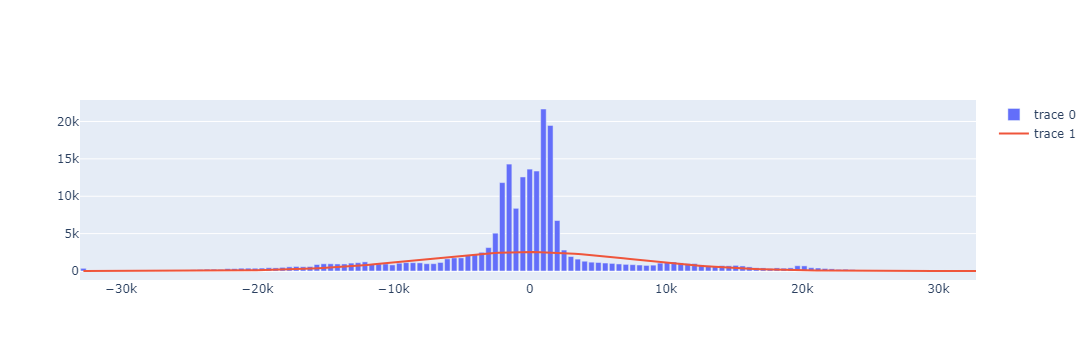

In [245]:
freq, y, bins, fig = dist_with_pdf(train_df['x'])
fig.show()

### Balance Train Data

In [246]:
train_aug_df = balance_data(train_df, freq, y, bins)

[LEFT] Flip 43, left=(-11091.038461538461, -10586.923076923074), right=(10585.923076923078, 11090.038461538461), y=982.1791799097779, freq=951, size=31
[LEFT] Flip 44, left=(-10586.923076923074, -10082.807692307691), right=(10081.807692307695, 10585.923076923078), y=1070.9409775322515, freq=952, size=118
[LEFT] Flip 45, left=(-10082.807692307691, -9578.692307692305), right=(9577.692307692312, 10081.807692307695), y=1162.8894570816476, freq=818, size=344
[LEFT] Flip 46, left=(-9578.692307692305, -9074.576923076922), right=(9073.576923076922, 9577.692307692312), y=1257.5041131099038, freq=1042, size=215
[LEFT] Flip 47, left=(-9074.576923076922, -8570.461538461539), right=(8569.461538461539, 9073.576923076922), y=1354.1864988152718, freq=1119, size=235
[LEFT] Flip 48, left=(-8570.461538461539, -8066.346153846152), right=(8065.346153846156, 8569.461538461539), y=1452.2641918319616, freq=1113, size=339
[LEFT] Flip 49, left=(-8066.346153846152, -7562.2307692307695), right=(7561.230769230773,

C:\Users\anurag.ANURAG-DESKTOP\AppData\Local\Temp\ipykernel_22244\2942613826.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anurag.ANURAG-DESKTOP\AppData\Local\Temp\ipykernel_22244\2942613826.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anurag.ANURAG-DESKTOP\AppData\Local\Temp\ipykernel_22244\2942613826.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

[RIGHT] Flip 72, left=(-4033.4230769230744, -3529.3076923076915), right=(3528.307692307695, 4032.423076923078), y=2240.177844783549, freq=1590, size=650
[RIGHT] Flip 73, left=(-4537.538461538461, -4033.4230769230744), right=(4032.423076923078, 4536.538461538461), y=2165.7172408824704, freq=1309, size=856
[RIGHT] Flip 74, left=(-5041.653846153844, -4537.538461538461), right=(4536.538461538461, 5040.653846153851), y=2085.0625803036564, freq=1183, size=902
[RIGHT] Flip 75, left=(-5545.7692307692305, -5041.653846153844), right=(5040.653846153851, 5544.769230769234), y=1999.0999987749046, freq=1139, size=860
[RIGHT] Flip 76, left=(-6049.884615384613, -5545.7692307692305), right=(5544.769230769234, 6048.884615384617), y=1908.7455070514554, freq=1066, size=842
[RIGHT] Flip 77, left=(-6554.0, -6049.884615384613), right=(6048.884615384617, 6553.0), y=1814.9289199162206, freq=1016, size=798
[RIGHT] Flip 78, left=(-7058.115384615383, -6554.0), right=(6553.0, 7057.11538461539), y=1718.578199426931

In [247]:
train_aug_df['x'] += 32768

### Plot Balanced Data

32624.70731190178 8233.562825452756 67791556.80067757


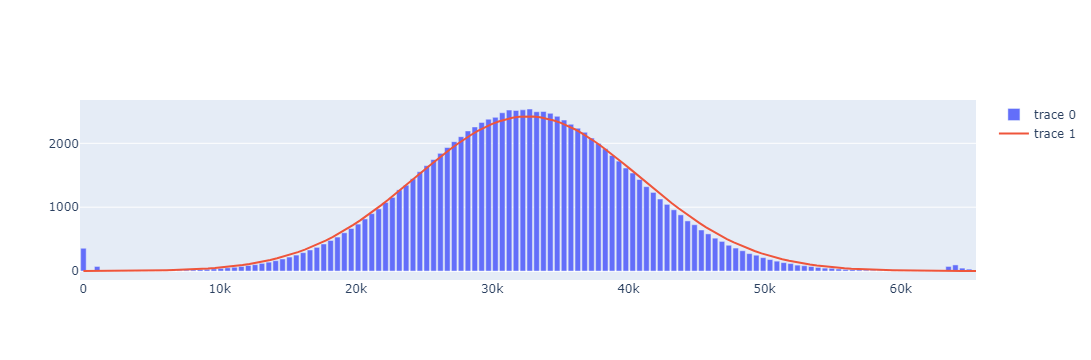

In [248]:
aug_freq, aug_y, aug_bins, aug_fig = dist_with_pdf(train_aug_df['x'])
aug_fig.show()

### Remove Outliers from Balanced Data

In [249]:
lb, ub = determine_outlier_thresholds_std(train_aug_df, 'x')
print(lb, ub)

7923.894139067594 57325.52048473597


In [250]:
train_aug_df = train_aug_df[(train_aug_df.x > lb) & (train_aug_df.x < ub)]

### Plot Data after removing outliers

32691.746273519588 7753.258508611418 60113017.50135535


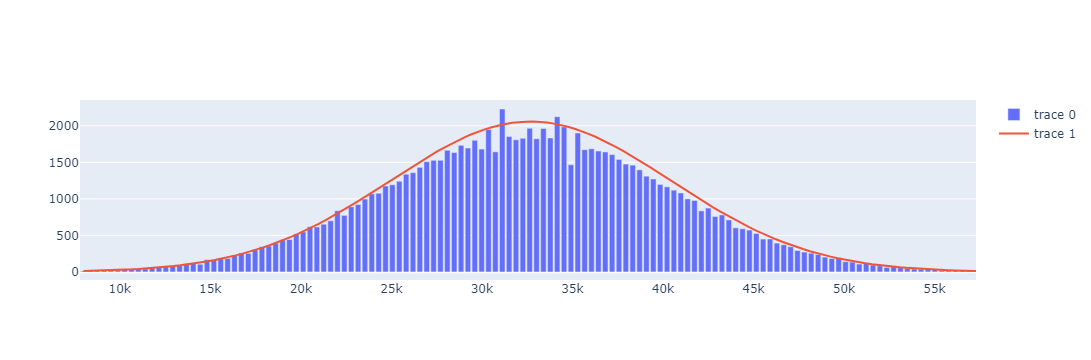

In [251]:
aug1_freq, aug1_y, aug1_bins, aug1_fig = dist_with_pdf(train_aug_df['x'], pdf_scale=4e7)
aug1_fig.show()

### Save Training Data

In [293]:
train_aug_df.to_csv("E:/data/training_data/annotations/v2_balanced_data_train_98k.csv", index=False)

## Balance Test Data

### Plot Test Data

-143.3506305914513 7932.836147747176 62929889.34700426


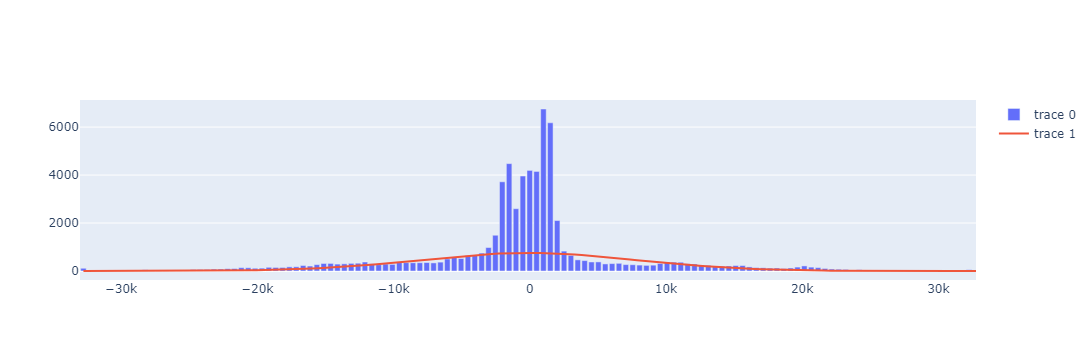

In [257]:
test_freq, test_y, test_bins, test_fig = dist_with_pdf(test_df['x'], pdf_scale=1.5e7)
test_fig.show()

### Balance Test Data

In [258]:
test_aug_df = balance_data(test_df, test_freq, test_y, test_bins)

[LEFT] Flip 43, left=(-11091.038461538461, -10586.923076923074), right=(10585.923076923078, 11090.038461538461), y=299.6454589311171, freq=265, size=34
[LEFT] Flip 44, left=(-10586.923076923074, -10082.807692307691), right=(10081.807692307695, 10585.923076923078), y=326.2199399938216, freq=291, size=35
[LEFT] Flip 45, left=(-10082.807692307691, -9578.692307692305), right=(9577.692307692312, 10081.807692307695), y=353.6976554550519, freq=277, size=76
[LEFT] Flip 46, left=(-9578.692307692305, -9074.576923076922), right=(9073.576923076922, 9577.692307692312), y=381.92029140021793, freq=351, size=30
[LEFT] Flip 47, left=(-9074.576923076922, -8570.461538461539), right=(8569.461538461539, 9073.576923076922), y=410.7070515831886, freq=349, size=61
[LEFT] Flip 48, left=(-8570.461538461539, -8066.346153846152), right=(8065.346153846156, 8569.461538461539), y=439.85593915203714, freq=344, size=95
[LEFT] Flip 49, left=(-8066.346153846152, -7562.2307692307695), right=(7561.230769230773, 8065.34615

C:\Users\anurag.ANURAG-DESKTOP\AppData\Local\Temp\ipykernel_22244\2942613826.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anurag.ANURAG-DESKTOP\AppData\Local\Temp\ipykernel_22244\2942613826.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anurag.ANURAG-DESKTOP\AppData\Local\Temp\ipykernel_22244\2942613826.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

[RIGHT] Flip 73, left=(-4537.538461538461, -4033.4230769230744), right=(4032.423076923078, 4536.538461538461), y=644.0241963123564, freq=434, size=210
[RIGHT] Flip 74, left=(-5041.653846153844, -4537.538461538461), right=(4536.538461538461, 5040.653846153851), y=619.9707802598147, freq=376, size=243
[RIGHT] Flip 75, left=(-5545.7692307692305, -5041.653846153844), right=(5040.653846153851, 5544.769230769234), y=594.3730819022854, freq=379, size=215
[RIGHT] Flip 76, left=(-6049.884615384613, -5545.7692307692305), right=(5544.769230769234, 6048.884615384617), y=567.5000690327437, freq=295, size=272
[RIGHT] Flip 77, left=(-6554.0, -6049.884615384613), right=(6048.884615384617, 6553.0), y=539.6244003712517, freq=309, size=230
[RIGHT] Flip 78, left=(-7058.115384615383, -6554.0), right=(6553.0, 7057.11538461539), y=511.0179011796448, freq=320, size=191
[RIGHT] Flip 79, left=(-7562.2307692307695, -7058.115384615383), right=(7057.11538461539, 7561.230769230773), y=481.94726855051323, freq=267, 

In [259]:
test_aug_df['x'] += 32768

### Plot Balanced Data

32594.03418174521 8628.796456083188 74456128.2805138


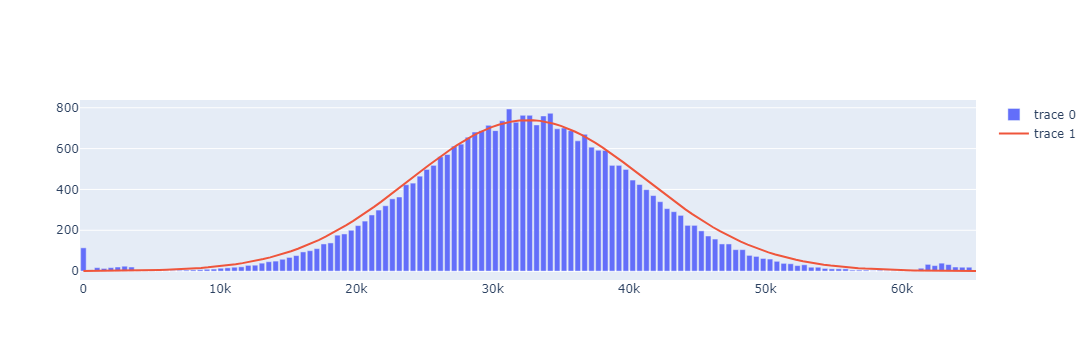

In [263]:
test_aug_freq, test_aug_y, test_aug_bins, test_aug_fig = dist_with_pdf(test_aug_df['x'], pdf_scale=1.6e7)
test_aug_fig.show()

### Remove Outliers from Balanced Data

In [264]:
lb, ub = determine_outlier_thresholds_std(test_aug_df, 'x')
print(lb, ub)

6707.211905392822 58480.856458097594


In [265]:
test_aug_df = test_aug_df[(test_aug_df.x > lb) & (test_aug_df.x < ub)]

### Plot Data after removing outliers

32625.697286650593 7806.1803359572095 60936451.43748501


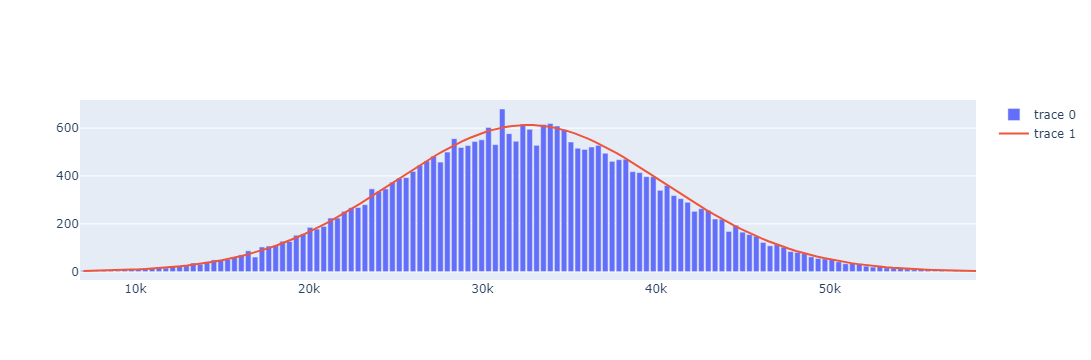

In [270]:
test_aug_freq1, test_aug_y1, test_aug_bins1, test_aug_fig1 = dist_with_pdf(test_aug_df['x'], pdf_scale=1.2e7)
test_aug_fig1.show()

### Save Test Data

In [276]:
test_aug_df.shape

(29447, 7)

In [277]:
test_aug_df.to_csv("E:/data/training_data/annotations/v2_balanced_data_test_29k.csv", index=False)

In [271]:
test_aug_df.shape

(29447, 7)

## Balance Val Data

### Plot Val Data

-67.0386355252684 7959.4630022408455 63353051.28404086


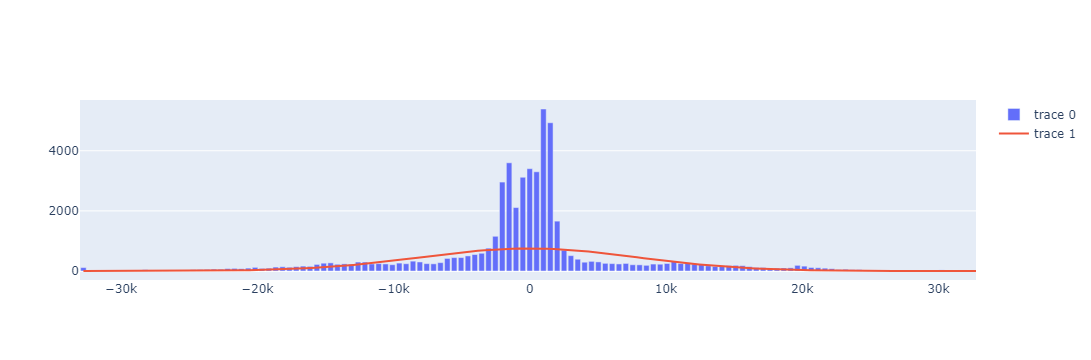

In [279]:
val_freq, val_y, val_bins, val_fig = dist_with_pdf(val_df['x'], pdf_scale=1.5e7)
val_fig.show()

### Balance Val Data

In [280]:
val_aug_df = balance_data(val_df, val_freq, val_y, val_bins)

[LEFT] Flip 42, left=(-11595.153846153844, -11091.038461538461), right=(11090.038461538461, 11594.153846153851), y=271.3190015860636, freq=236, size=35
[LEFT] Flip 43, left=(-11091.038461538461, -10586.923076923074), right=(10585.923076923078, 11090.038461538461), y=296.600251294039, freq=246, size=50
[LEFT] Flip 44, left=(-10586.923076923074, -10082.807692307691), right=(10081.807692307695, 10585.923076923078), y=322.9189936695348, freq=235, size=87
[LEFT] Flip 45, left=(-10082.807692307691, -9578.692307692305), right=(9577.692307692312, 10081.807692307695), y=350.14379742814936, freq=210, size=140
[LEFT] Flip 46, left=(-9578.692307692305, -9074.576923076922), right=(9073.576923076922, 9577.692307692312), y=378.1203541379107, freq=263, size=115
[LEFT] Flip 47, left=(-9074.576923076922, -8570.461538461539), right=(8569.461538461539, 9073.576923076922), y=406.672163131505, freq=242, size=164
[LEFT] Flip 48, left=(-8570.461538461539, -8066.346153846152), right=(8065.346153846156, 8569.46

C:\Users\anurag.ANURAG-DESKTOP\AppData\Local\Temp\ipykernel_22244\2942613826.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anurag.ANURAG-DESKTOP\AppData\Local\Temp\ipykernel_22244\2942613826.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anurag.ANURAG-DESKTOP\AppData\Local\Temp\ipykernel_22244\2942613826.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

[RIGHT] Flip 72, left=(-4033.4230769230744, -3529.3076923076915), right=(3528.307692307695, 4032.423076923078), y=667.7361407945082, freq=392, size=275
[RIGHT] Flip 73, left=(-4537.538461538461, -4033.4230769230744), right=(4032.423076923078, 4536.538461538461), y=645.9803804538516, freq=293, size=352
[RIGHT] Flip 74, left=(-5041.653846153844, -4537.538461538461), right=(4536.538461538461, 5040.653846153851), y=622.3927776869897, freq=321, size=301
[RIGHT] Flip 75, left=(-5545.7692307692305, -5041.653846153844), right=(5040.653846153851, 5544.769230769234), y=597.2285109955079, freq=303, size=294
[RIGHT] Flip 76, left=(-6049.884615384613, -5545.7692307692305), right=(5544.769230769234, 6048.884615384617), y=570.751802177976, freq=255, size=315
[RIGHT] Flip 77, left=(-6554.0, -6049.884615384613), right=(6048.884615384617, 6553.0), y=543.231346014535, freq=246, size=297
[RIGHT] Flip 78, left=(-7058.115384615383, -6554.0), right=(6553.0, 7057.11538461539), y=514.9358445018001, freq=235, s

In [281]:
val_aug_df['x'] += 32768

### Plot Balanced Data

32673.23203582733 8557.076716121337 73223561.92558593


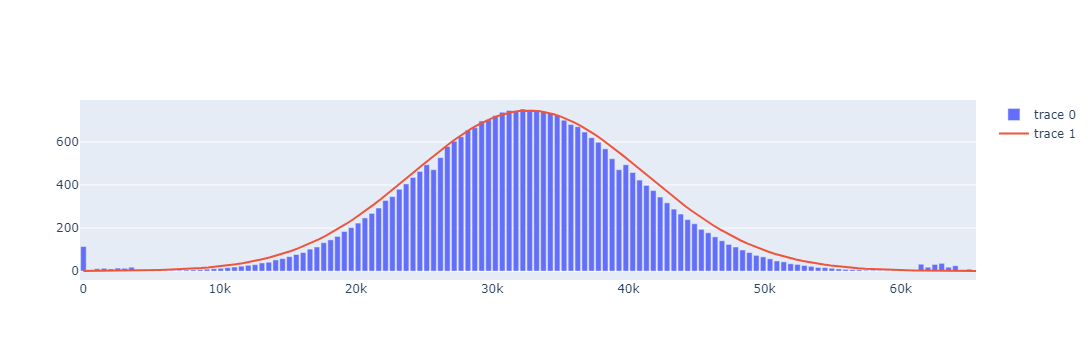

In [285]:
val_aug_freq, val_aug_y, val_aug_bins, val_aug_fig = dist_with_pdf(val_aug_df['x'], pdf_scale=1.6e7)
val_aug_fig.show()

### Remove Outliers from Balanced Data

In [286]:
lb, ub = determine_outlier_thresholds_std(val_aug_df, 'x')
print(lb, ub)

7001.569671851597 58344.89439980306


In [287]:
val_aug_df = val_aug_df[(val_aug_df.x > lb) & (val_aug_df.x < ub)]

### Plot Data after removing outliers

32704.78701839402 7832.072510189045 61341359.80485892


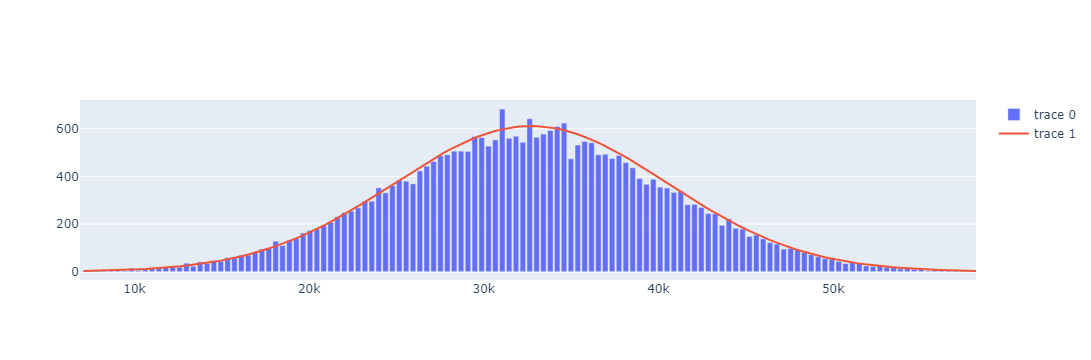

In [288]:
val_aug_freq1, val_aug_y1, val_aug_bins1, val_aug_fig1 = dist_with_pdf(val_aug_df['x'], pdf_scale=1.2e7)
val_aug_fig1.show()

### Save Val Data

In [291]:
val_aug_df.shape

(29303, 7)

In [292]:
val_aug_df.to_csv("E:/data/training_data/annotations/v2_balanced_data_val_29k.csv", index=False)

In [272]:
# train_aug_df.to_csv("E:/data/training_data/annotations/v2_balanced_data_train_98k.csv", index=False)

(98216, 11)

In [274]:
29447/(98216+29447)

0.23066197723694415

89.42341214083532 29.65216097828949 879.2506506823939


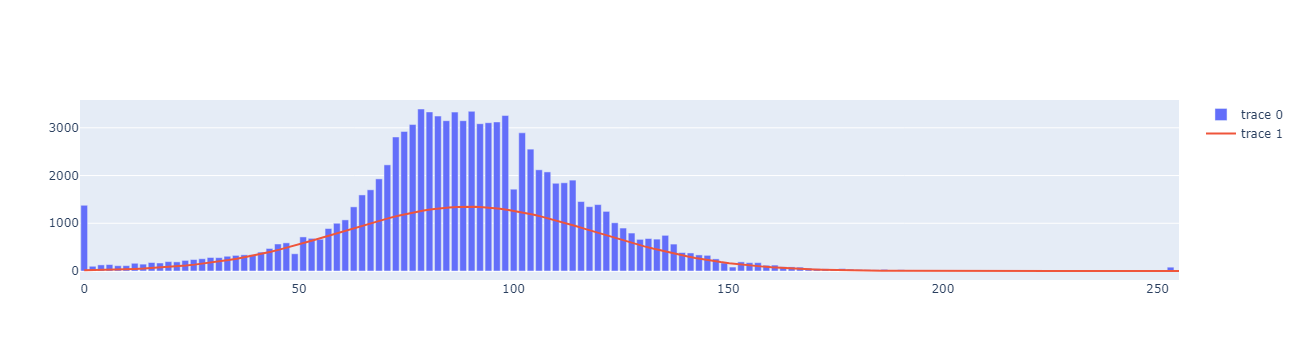

In [143]:
data= aug_df['rt']
freq, bins = np.histogram(data, bins=130)

# calculate mean and standard deviation
mean = np.mean(data)
std = np.std(data)
var = np.var(data)
print(mean, std, var)

# create x-axis values for the normal distribution curve
mu = 0
sigma = math.sqrt(var)
x = np.linspace(min(bins), max(bins), 130)


# calculate the y-axis values for the normal distribution curve
y = stats.norm.pdf(x, mean, std) * 1e5


fig = go.Figure([
    go.Bar(x=bins[:-1], y=freq), 
    go.Scatter(x=x, y=y),
])
fig.show()

# # plot the frequency distribution and normal distribution curves
# plt.bar(bins[:-1], freq, width=500,  label='Frequency Distribution')
# plt.plot(x, y, color = "red", label='Normal Distribution')

# # add legend and axis labels
# plt.legend()
# plt.xlabel('Value')
# plt.ylabel('Frequency')

# # show the plot
# plt.show()

In [62]:
32767 * 2

65534

In [61]:
aug_df.x.max()

58006

In [58]:
aug_df.to_csv("E:/data/training_data/annotations/v2_balanced_data_75k.csv", index=False)

In [1]:
194863/128

1522.3671875

In [30]:
import imblearn

In [29]:
from sklearn.utils import shuffle

In [ ]:
bins = range(1000,2000, 500)
# bins = sorted(df['x_bin'].unique())
remove_list = list()
bin_threshold = 18000
for b in bins:
    # print("Bin", b)
    tdf = df[df['x_bin'] == b]
    # print("Filtered result size", tdf.shape[0])
    idx_list = [t.Index for t in tdf.itertuples()]
    remove_list += shuffle(idx_list)[bin_threshold:]

In [ ]:
print(len(remove_list))
remove_set = set(remove_list)
print(len(remove_set))

In [ ]:
df['remove'] = df.index.map(lambda x : x in remove_set)
balanced_df = df[df['remove'] == False]

In [ ]:
balanced_df = balanced_df[balanced_df['rt']<=180]

In [ ]:
df.shape, balanced_df.shape

In [ ]:
# balanced_df_prime = balanced_df[["x", 'y', 'lt', 'rt', 'rb', "image", 'x_bin', 'rt_bin', 'lt_bin', ]][(balanced_df.x <= 0) & (balanced_df.x >= 2000 )]

In [ ]:
bhist, bbins = np.histogram(balanced_df['x'], bins=130)
center = (bbins[:-1] + bbins[1:]) * 0.5

In [ ]:
px.bar(x=center, y=bhist)

In [ ]:
df_agg = balanced_df[['x_bin']].groupby('x_bin').size().reset_index().rename(columns = {0: "count"})
px.bar(x=df_agg.x_bin.values, y=df_agg['count'].values)

In [ ]:
rthist, rtbins = np.histogram(balanced_df['rt'], bins=20)
center = (rtbins[:-1] + rtbins[1:]) * 0.5

In [ ]:
px.bar(x=center, y=rthist)

In [ ]:
df_agg = balanced_df[['rt_bin']].groupby('rt_bin').size().reset_index().rename(columns = {0: "count"})
px.bar(x=df_agg.rt_bin.values, y=df_agg['count'].values)

In [ ]:
balanced_df

# Image transforms

In [265]:
aug = torch.nn.Sequential(
    T.RandomAdjustSharpness(1.5, p=0.5),
    T.RandomErasing(0.5, scale=(0.02, 0.2)),
    T.RandomAutocontrast(0.5),
    T.RandomPerspective(distortion_scale=0.1, p=0.5)
)

In [266]:
transform = torch.nn.Sequential(
    T.Resize(size=(224,224)),
    T.Grayscale(),
    T.ConvertImageDtype(torch.float32)
)

In [267]:
image_path =df.iloc[156].image
image_path

'E:/data/training_data/images/v2\\1676993292672.jpg'

In [268]:
image_path =df.iloc[157].image
image_path

'E:/data/training_data/images/v2\\1676993292688.jpg'

In [269]:
torch_img1 = read_image(image_path,  ImageReadMode.RGB)

In [270]:
torch_img2 = read_image(image_path)

In [271]:
torch_img1 = transform(torch_img1)
# torch_img2 = transform(torch_img2)

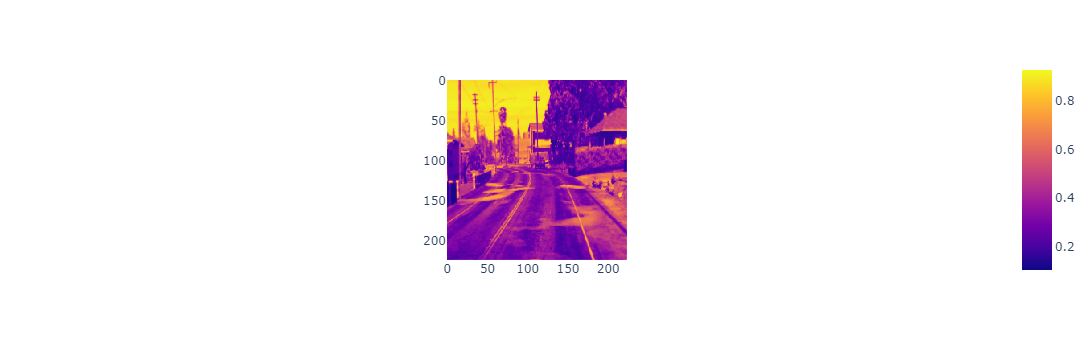

In [272]:
# torch_img1 = 
px.imshow(torch_img1.permute(1, 2, 0).numpy()[:,:,0])

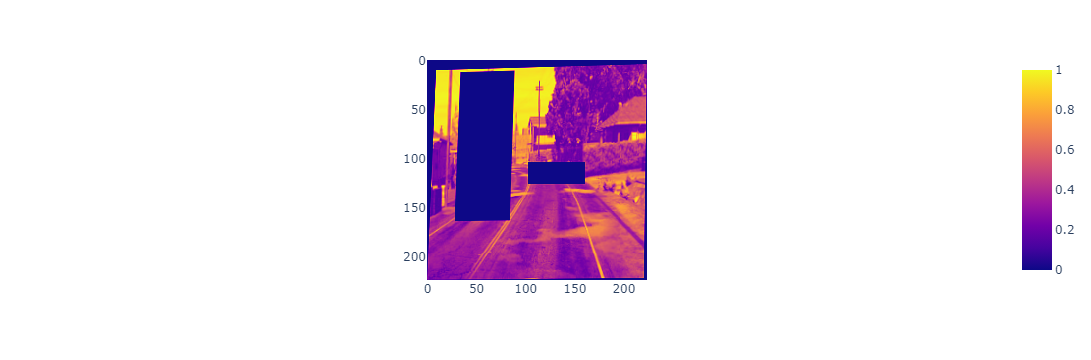

In [ ]:
torch_img1 = aug(torch_img1)
px.imshow(torch_img1.permute(1, 2, 0).numpy()[:,:,0])

In [255]:
flat_img1 = torch_img1.flatten()
flat_img2 = torch_img2.flatten()

In [243]:
features = torch.stack([flat_img1, flat_img2])

RuntimeError: stack expects each tensor to be equal size, but got [50176] at entry 0 and [187500] at entry 1

In [ ]:
torch.cdist(features, features)

In [ ]:
torch.cdist(features, features)

In [ ]:
# filtered_df.to_csv("E:/data/training_data/annotations_200k_v2.csv", index=False)

# Image Analysis

In [ ]:
pil_image = T.ToPILImage()

In [ ]:
def wait_for_q():
    if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        raise Exception("Quit windows called")

In [ ]:
def augment(img):
    seq = iaa.Sequential([
        # iaa.Crop(px=(0, 40)), # crop images from each side by 0 to 16px (randomly chosen)
        # iaa.Resize(0.95),
        # iaa.Fliplr(0.5), # horizontally flip 50% of the images
        # iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
        iaa.Multiply((0.2, 1.2)),
        # iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
    ])
    return seq(images=[img])

In [ ]:
transform = torch.nn.Sequential(
    T.Grayscale(), 
    T.ConvertImageDtype(torch.float32),
    # T.Resize((64, 64))
)

In [ ]:
df[(df.x == 0) & (df['lt'] ==0)].shape

In [ ]:
image_path = df.iloc[888].image

In [ ]:
torch_img1 = read_image(image_path,  ImageReadMode.RGB)
torch_img1 = torch_img1.permute(1, 2, 0).numpy()

In [ ]:
image_path = df.iloc[887].image

In [ ]:
torch_img2 = read_image(image_path,  ImageReadMode.RGB)
torch_img2 = torch_img2.permute(1, 2, 0).numpy()

In [ ]:
px.imshow(torch_img1)

In [ ]:
px.imshow(torch_img2)

In [ ]:
torch_img = read_image(image_path,  ImageReadMode.RGB)
aug_img = transform(torch_img)
# grey_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
img = torch_img.permute(1, 2, 0).numpy()
aug_img = aug_img.permute(1, 2, 0).numpy()

In [ ]:
# npad = ((0, 0), (0, 0), (2, 0))
# px.imshow(np.pad(aug_img, npad, mode="reflect"))

In [ ]:
px.imshow(img)

In [ ]:
px.imshow(aug_img.squeeze())

In [ ]:
index = 97433
for t in df.iloc[index-2:index+5].itertuples():
    fig = px.imshow(io.imread(t.image))
    print(t)
    fig.show()

In [ ]:
df[df.x < 0].shape

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(df[["x", "rt", "lt"]])

In [ ]:
df.max()

In [ ]:
pd.DataFrame(scaler.fit_transform(df[["x", "rt", "lt"]]))

In [ ]:
df['lt'].max()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
scaler = MinMaxScaler((-1, 255))
scaler.fit_transform(np.array(range(0, 32767)).reshape(-1, 1))[1000]

In [ ]:
df.iloc[0].x

In [ ]:
max_val = 32767

In [ ]:
def get_z_axis(lt, rt):
    if lt == rt == 0:
        return 0
    z_axis = (lt - rt) * 128 + 32767
    z_axis = max(0, min(z_axis, 32767*2))

    return z_axis//2

In [ ]:
get_z_axis(1,0) * 2

In [ ]:
get_z_axis(255, 128)

In [ ]:
32767 - 225  * (32767/255)